In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available")

NVIDIA GeForce GTX 1660 SUPER


In [27]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = True)



In [69]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(5, 10, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(10*7*7, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(-1, 10*7*7)
        x = self.fc1(x)
        return x

model = Model()
# model.load_state_dict(torch.load('mnist_model.pth', weights_only=True))


In [56]:
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    correct = 0
    for data, target in test_loader:
        with torch.no_grad():
            output = model(data)
            correct += (output.argmax(dim=1) == target).sum()
    accuracy = correct / 10000
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, accuracy: {accuracy:.4f}")



Epoch 1, Loss: 0.0376, accuracy: 0.9812
Epoch 2, Loss: 0.0388, accuracy: 0.9839
Epoch 3, Loss: 0.1729, accuracy: 0.9838
Epoch 4, Loss: 0.0452, accuracy: 0.9841
Epoch 5, Loss: 0.3120, accuracy: 0.9855
Epoch 6, Loss: 0.0760, accuracy: 0.9876
Epoch 7, Loss: 0.0215, accuracy: 0.9880
Epoch 8, Loss: 0.0879, accuracy: 0.9888
Epoch 9, Loss: 0.0121, accuracy: 0.9888
Epoch 10, Loss: 0.1084, accuracy: 0.9895


In [68]:
torch.save(model.state_dict(), 'mnist_model.pth')

# Search for index of image that is misclassified

6
259
[[0.7  0.   0.   0.   0.   0.   0.29 0.   0.   0.  ]]


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

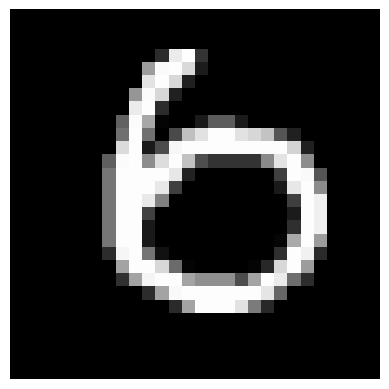

In [57]:
model.eval()
index = None
for i, (data, target) in enumerate(test_loader.dataset):
    with torch.no_grad():
        pred = model(data.unsqueeze(0))
    if np.argmax(F.softmax(pred, dim=1).detach().numpy()) != target:
        index = i
        break
print(target)
print(index)
print(F.softmax(pred, dim=1).detach().numpy().round(2))
plt.imshow(data.squeeze(), cmap='gray')
plt.axis('off')

# Define function to visualize conv layer

In [48]:
def visualize_conv_layer(model, data, conv_index):
    model.eval()

    conv_output = None
    
    # 후크(hook) 함수 정의
    def hook_fn(model, data, output):
        nonlocal conv_output
        conv_output = output.detach()
    
    # 원하는 conv 레이어 찾기
    target_conv = None
    if conv_index == 1:
        target_conv = model.conv1
    elif conv_index == 2:
        target_conv = model.conv2
    elif conv_index == 3:
        target_conv = model.conv3
    
    # 후크 등록
    hook = target_conv.register_forward_hook(hook_fn)
    
    # 데이터 forward
    with torch.no_grad():
        _ = model(data.unsqueeze(0))
    
    # 후크 제거
    hook.remove()
    
    # 필터 출력 시각화
    fig, axes = plt.subplots(1, conv_output.shape[1], figsize=(15, 3))
    for idx in range(conv_output.shape[1]):
        axes[idx].imshow(conv_output[0, idx].numpy(), cmap='gray')
        axes[idx].set_title(f'Filter {idx+1}')
    plt.tight_layout()
    plt.show()
    
    return conv_output

# Visualize conv layer for misclassified image

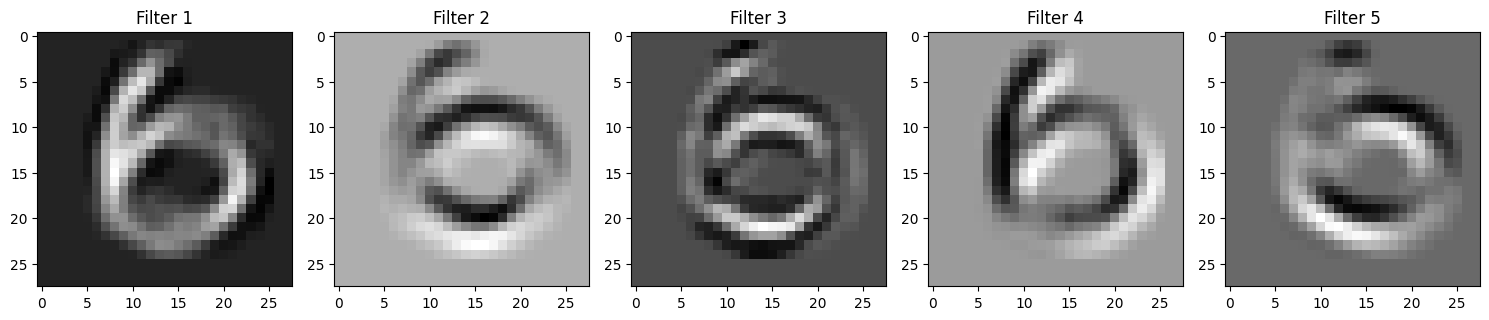

In [58]:
index = 259
image = test_loader.dataset[index][0]
conv_index = 1

output = visualize_conv_layer(model, image, conv_index)

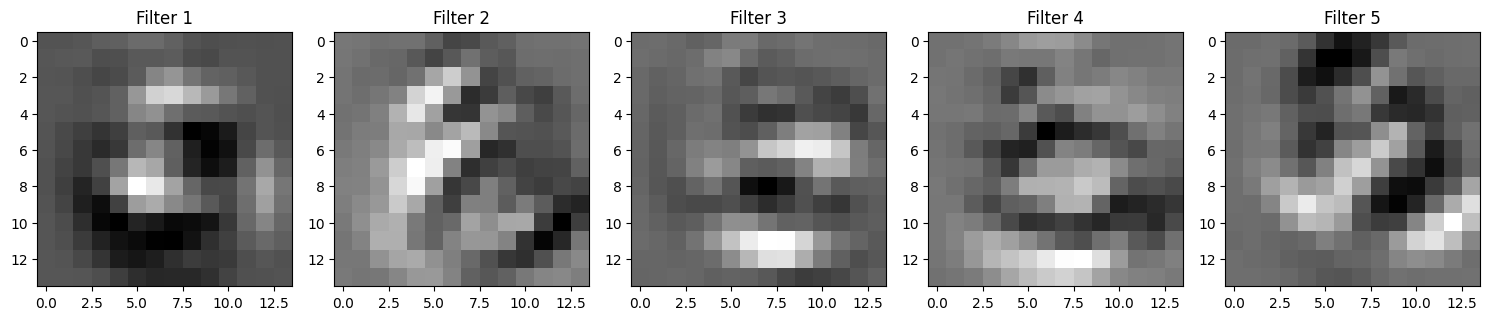

In [59]:
conv_index = 2

output1 = visualize_conv_layer(model, image, conv_index)

# Visualize conv layer for image whose label is 0

In [60]:
model.eval()
index = 0
for i, (data, target) in enumerate(test_loader.dataset):
    with torch.no_grad():
        pred = model(data.unsqueeze(0))
    if target == 0:
        index = i
        break
print(index)

3


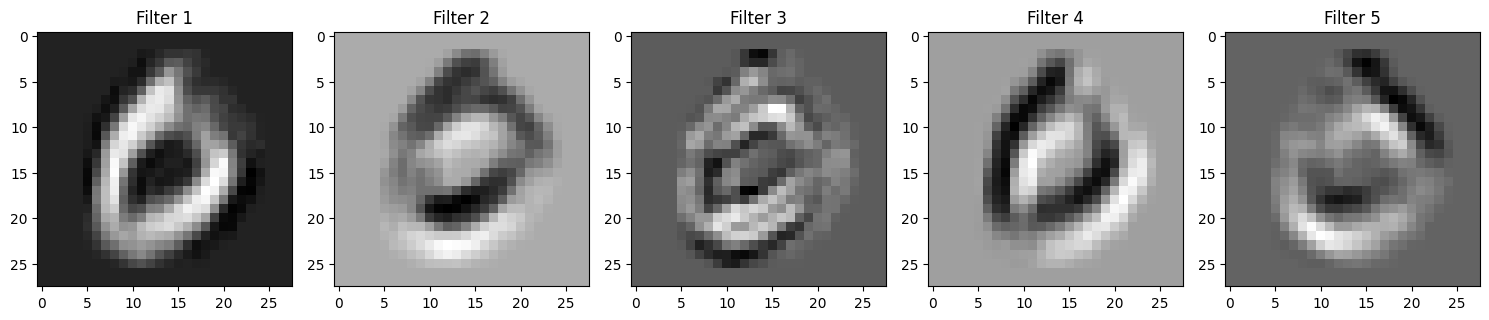

In [61]:
image = test_loader.dataset[index][0]
conv_index = 1

output = visualize_conv_layer(model, image, conv_index)

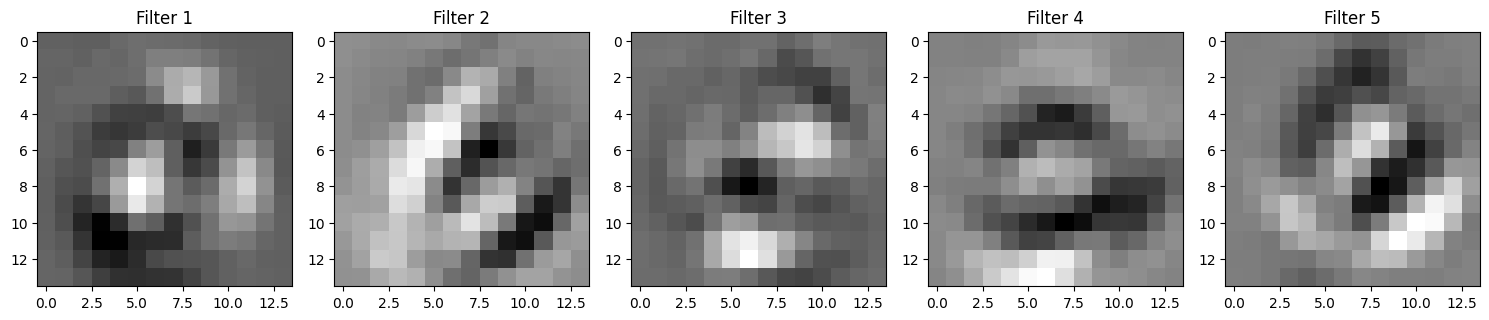

In [62]:
conv_index = 2

output2 = visualize_conv_layer(model, image, conv_index)

# Visualize conv layer for image whose label is 6


In [63]:
model.eval()
index = None
for i, (data, target) in enumerate(test_loader.dataset):
    with torch.no_grad():
        pred = model(data.unsqueeze(0))
    if target == 6:
        index = i
        break
print(index)

11


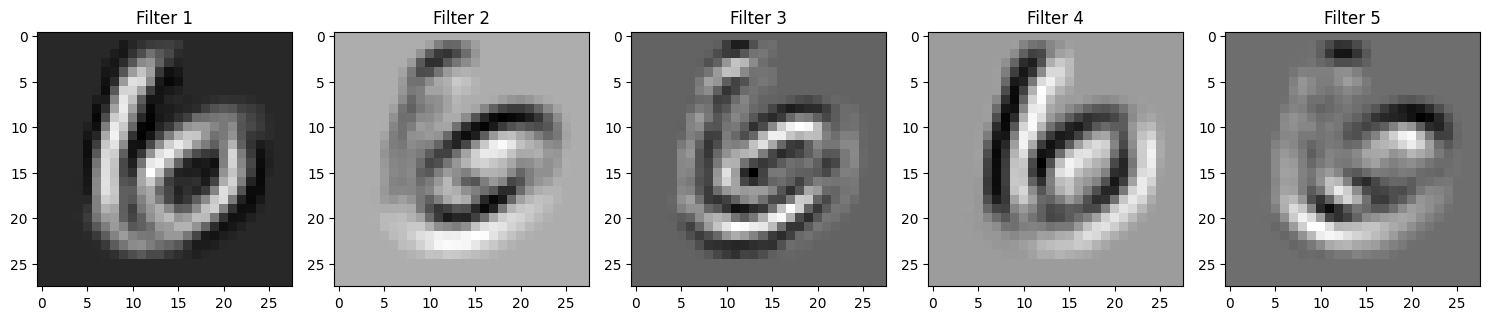

In [64]:
image = test_loader.dataset[index][0]
conv_index = 1

output = visualize_conv_layer(model, image, conv_index)

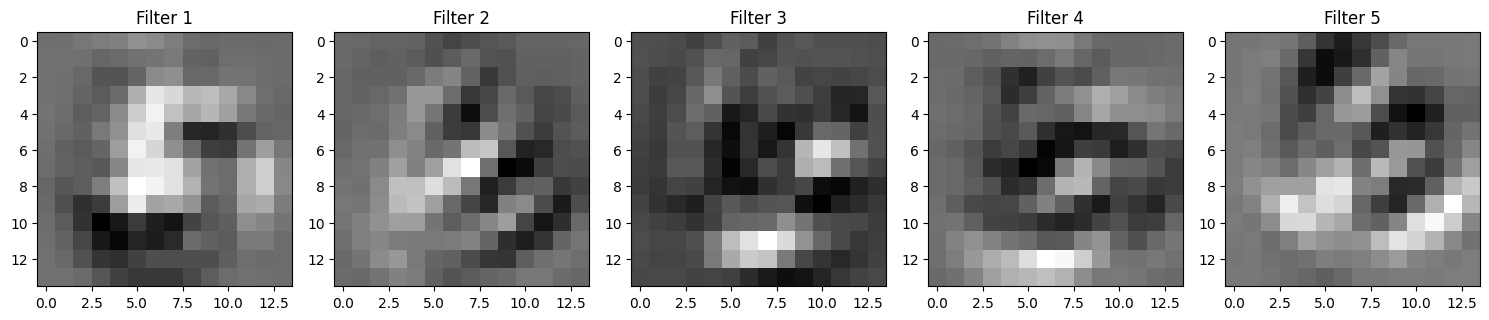

In [66]:
conv_index = 2

output3 = visualize_conv_layer(model, image, conv_index)

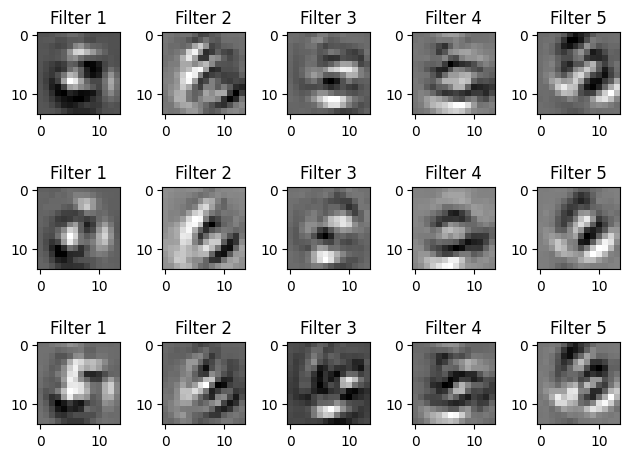

In [67]:
fig, axes = plt.subplots(3, 5)
outputs = [output1, output2, output3]
for idx in range(3):
    for jdx in range(5):
        axes[idx, jdx].imshow(outputs[idx][0, jdx].numpy(), cmap='gray')
        axes[idx, jdx].set_title(f'Filter {jdx+1}')
plt.tight_layout()
plt.show()